In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json

!kaggle datasets download -d 'yassershrief/hockey-fight-vidoes'

 93% 153M/164M [00:01<00:00, 112MB/s]
100% 164M/164M [00:01<00:00, 103MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile("hockey-fight-vidoes.zip","r") as zip_ref:
    zip_ref.extractall("hockey-fight-vidoes")

In [ ]:
%matplotlib inline
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
# import download
from random import shuffle
from tensorflow.keras.applications import densenet
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation
import sys
import h5py

In [ ]:
keras.__version__

'2.5.0'

In [ ]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

In [ ]:
in_dir = "hockey-fight-vidoes/data"

In [ ]:
# Frame size  
img_size = 224

img_size_touple = (img_size, img_size)

# Number of channels (RGB)
num_channels = 3

# Flat frame size
img_size_flat = img_size * img_size * num_channels

# Number of classes for classification (Violence-No Violence)
num_classes = 2

# Number of files to train
_num_files_train = 1

# Number of frames per video
_images_per_file = 20

# Number of frames per training set
_num_images_train = _num_files_train * _images_per_file

# Video extension
video_exts = ".avi"

In [ ]:
def get_frames(current_dir, file_name):
    
    in_file = os.path.join(current_dir, file_name)
    
    images = []
    
    vidcap = cv2.VideoCapture(in_file)
    
    success,image = vidcap.read()
        
    count = 0

    while count<_images_per_file:
                
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)
    
        images.append(res)
    
        success,image = vidcap.read()
    
        count += 1
        
    resul = np.array(images)
    
    resul = (resul / 255.).astype(np.float16)
        
    return resul

In [ ]:
def label_video_names(in_dir):
    
    # list containing video names
    names = []
    # list containin video labels [1, 0] if it has violence and [0, 1] if not
    labels = []
    
    
    for current_dir, dir_names,file_names in os.walk(in_dir):
        
        for file_name in file_names:
            
            if file_name[0:2] == 'fi':
                labels.append([1,0])
                names.append(file_name)
            elif file_name[0:2] == 'no':
                labels.append([0,1])
                names.append(file_name)
                     
            
    c = list(zip(names,labels))
    # Suffle the data (names and labels)
    shuffle(c)
    
    names, labels = zip(*c)
            
    return names, labels

In [ ]:
# First get the names and labels of the whole videos
names, labels = label_video_names(in_dir)

In [ ]:
names[12]

'fi171_xvid.avi'

In [ ]:
frames = get_frames(in_dir, names[12])

In [ ]:
visible_frame = (frames*255).astype('uint8')

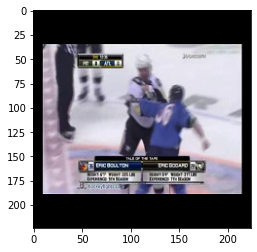

In [ ]:
plt.imshow(visible_frame[3])

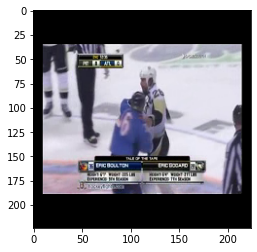

In [ ]:
plt.imshow(visible_frame[15])

In [ ]:
image_model = densenet.DenseNet121(include_top=True, weights='imagenet')

33193984/33188688 [==============================] - 0s 0us/step


In [ ]:
image_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
# We will use the output of the layer prior to the final
# classification-layer which is named fc2. This is a fully-connected (or dense) layer.
transfer_layer = image_model.get_layer('avg_pool')

image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

transfer_values_size = K.int_shape(transfer_layer.output)[1]


print("The input of the VGG16 net have dimensions:",K.int_shape(image_model.input)[1:3])

print("The output of the selecter layer of VGG16 net have dimensions: ", transfer_values_size)

The input of the VGG16 net have dimensions: (224, 224)
The output of the selecter layer of VGG16 net have dimensions:  1024


In [ ]:
def get_transfer_values(current_dir, file_name):
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    image_batch = np.zeros(shape=shape, dtype=np.float16)
    
    image_batch = get_frames(current_dir, file_name)
      
    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (_images_per_file, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    transfer_values = \
            image_model_transfer.predict(image_batch)
            
    return transfer_values

In [ ]:
def proces_transfer(vid_names, in_dir, labels):
    
    count = 0
    
    tam = len(vid_names)
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    while count<tam:
        
        video_name = vid_names[count]
        
        image_batch = np.zeros(shape=shape, dtype=np.float16)
    
        image_batch = get_frames(in_dir, video_name)
        
         # Note that we use 16-bit floating-points to save memory.
        shape = (_images_per_file, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        
        transfer_values = \
            image_model_transfer.predict(image_batch)
         
        labels1 = labels[count]
        
        aux = np.ones([20,2])
        
        labelss = labels1*aux
        
        yield transfer_values, labelss
        
        count+=1

In [ ]:
def make_files(n_files):
    
    gen = proces_transfer(names_training, in_dir, labels_training)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('prueba.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [ ]:
def make_files_test(n_files):
    
    gen = proces_transfer(names_test, in_dir, labels_test)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('pruebavalidation.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [ ]:
training_set = int(len(names)*0.8)
test_set = int(len(names)*0.2)

names_training = names[0:training_set]
names_test = names[training_set:]

labels_training = labels[0:training_set]
labels_test = labels[training_set:]

In [ ]:
make_files(training_set)

- Progress: 99.9%

In [ ]:
make_files_test(test_set)

- Progress: 99.5%

In [ ]:
def process_alldata_training():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('prueba.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [ ]:
def process_alldata_test():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('pruebavalidation.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [ ]:
data, target = process_alldata_training()

In [ ]:
data_test, target_test = process_alldata_test()

In [ ]:
chunk_size = 1024
n_chunks = 20
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

In [ ]:
epoch = 200
batchS = 500

history = model.fit(np.array(data[0:720]), np.array(target[0:720]), epochs=epoch,
                    validation_data=(np.array(data[720:]), np.array(target[720:])), 
                    batch_size=batchS, verbose=2)

Epoch 1/200
2/2 - 3s - loss: 0.2962 - accuracy: 0.5333 - val_loss: 0.2171 - val_accuracy: 0.5125
Epoch 2/200
2/2 - 0s - loss: 0.1791 - accuracy: 0.6556 - val_loss: 0.1177 - val_accuracy: 0.8875
Epoch 3/200
2/2 - 0s - loss: 0.1046 - accuracy: 0.8972 - val_loss: 0.0948 - val_accuracy: 0.8625
Epoch 4/200
2/2 - 0s - loss: 0.0753 - accuracy: 0.9042 - val_loss: 0.0761 - val_accuracy: 0.9125
Epoch 5/200
2/2 - 0s - loss: 0.0669 - accuracy: 0.9167 - val_loss: 0.0727 - val_accuracy: 0.9125
Epoch 6/200
2/2 - 0s - loss: 0.0581 - accuracy: 0.9250 - val_loss: 0.0790 - val_accuracy: 0.9000
Epoch 7/200
2/2 - 0s - loss: 0.0552 - accuracy: 0.9292 - val_loss: 0.0656 - val_accuracy: 0.9125
Epoch 8/200
2/2 - 0s - loss: 0.0534 - accuracy: 0.9333 - val_loss: 0.0652 - val_accuracy: 0.9125
Epoch 9/200
2/2 - 0s - loss: 0.0462 - accuracy: 0.9486 - val_loss: 0.0693 - val_accuracy: 0.9250
Epoch 10/200
2/2 - 0s - loss: 0.0457 - accuracy: 0.9417 - val_loss: 0.0658 - val_accuracy: 0.9125
Epoch 11/200
2/2 - 0s - loss:

In [ ]:
result = model.evaluate(np.array(data_test), np.array(target_test))

7/7 [==============================] - 0s 4ms/step - loss: 0.0346 - accuracy: 0.9650


In [ ]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.03455158323049545
accuracy 0.9649999737739563


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


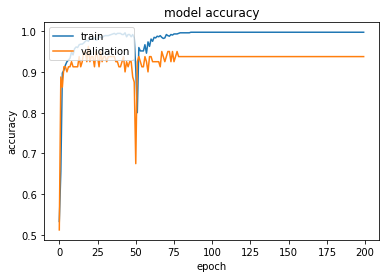

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


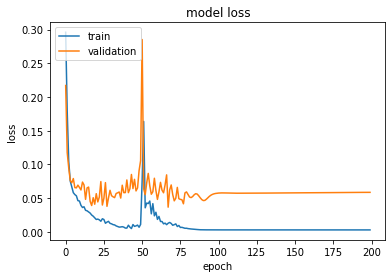

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()

In [ ]:
print(target_test)

[array([0., 1.]), array([1., 0.]), array([1., 0.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([1., 0.]), array([1., 0.]), array([0., 1.]), array([1., 0.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([1., 0.]), array([0., 1.]), array([1., 0.]), array([0., 1.]), array([1., 0.]), array([0., 1.]), array([1., 0.]), array([1., 0.]), array([0., 1.]), array([1., 0.]), array([0., 1.]), array([0., 1.]), array([1., 0.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([1., 0.]), array([0., 1.]), array([0., 1.]), array([1., 0.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([1., 0.]), array([0., 1.]), array([1., 0.]), array([0., 1.]), array([0., 1.]), array([1., 0.]), array([1., 0.]), array([1., 0.]), array([1., 0.]), array([1., 0.]), array([1., 0.]), array([0., 1.]), array([1., 0.]), array([1., 0.]), array([1., 0.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(np.array(data_test))
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
import numpy as np
target_test=np.argmax(target_test, axis=1)

In [ ]:
# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# confusion matrix
conf_matrix = confusion_matrix( np.array(target_test), y_pred)
print('Confusion matrix : \n',conf_matrix)

Confusion matrix : 
 [[ 84   1]
 [  6 109]]


In [ ]:
##########################
# SAVE #
##########################
model.save("Densenet-model")

##########################
# LOAD #
##########################
reconstructed_model = keras.models.load_model("Densenet-model")

INFO:tensorflow:Assets written to: Densenet-model/assets


INFO:tensorflow:Assets written to: Densenet-model/assets


In [ ]:
!zip -r "/content/Densenet-model.zip" "/content/Densenet-model"

  adding: content/Densenet-model/ (stored 0%)
  adding: content/Densenet-model/variables/ (stored 0%)
  adding: content/Densenet-model/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: content/Densenet-model/variables/variables.index (deflated 64%)
  adding: content/Densenet-model/assets/ (stored 0%)
  adding: content/Densenet-model/keras_metadata.pb (deflated 89%)
  adding: content/Densenet-model/saved_model.pb (deflated 89%)
